# Teams Clustering Dataset prepation

This notebook was used to create the clusters based on the styles of plays of NBA teams between 2012 and 2018.

## Data 

My data was acquired from Kaggle [click here to access the related webpage](https://www.kaggle.com/pablote/nba-enhanced-stats).

Here is the dataset's official description: 

> "Dataset is based on box score and standing statistics from the NBA.
Calculations such as number of possessions, floor impact counter, strength of schedule, and simple rating system are performed.
Finally, extracts are created based on a perspective:
* teamBoxScore.csv communicates game data from each teams perspective
* officialBoxScore.csv communicates game data from each officials perspective
* playerBoxScore.csv communicates game data from each players perspective
* standing.csv communicates standings data for each team every day during the season"

In the NBA, there are 30 teams split in two conferences, each conference having 3 divisions of 5 teams. For a list of the teams and divisions, please visite [NBA.com](https://www.nba.com/standings).



## Methodology 

My methodology is as follows: 

* Based on historical data, I classify teams as belonging to different types (e.g. fast/slow paced, 3pt shooting, assists numbers, etc.) by using a clustering algorithm (KMeans).
* I then use the players' dataset and isolate Damian Lillard's performances (done in separate Jupyter Notebook). 

The two datasets I will use are `2012-18_teamBoxScore.csv` and `2012-18_playerBoxScore.csv` 

In [1]:
# Import
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates

## Data Loading

In [2]:
teams = pd.read_csv('data/2012-18_teamBoxScore.csv')
teams.head()
teams.shape

(14758, 123)

In [3]:
for idx, c in enumerate(teams.columns): 
    print('Column {}: {}'.format(idx, c))

Column 0: gmDate
Column 1: gmTime
Column 2: seasTyp
Column 3: offLNm1
Column 4: offFNm1
Column 5: offLNm2
Column 6: offFNm2
Column 7: offLNm3
Column 8: offFNm3
Column 9: teamAbbr
Column 10: teamConf
Column 11: teamDiv
Column 12: teamLoc
Column 13: teamRslt
Column 14: teamMin
Column 15: teamDayOff
Column 16: teamPTS
Column 17: teamAST
Column 18: teamTO
Column 19: teamSTL
Column 20: teamBLK
Column 21: teamPF
Column 22: teamFGA
Column 23: teamFGM
Column 24: teamFG%
Column 25: team2PA
Column 26: team2PM
Column 27: team2P%
Column 28: team3PA
Column 29: team3PM
Column 30: team3P%
Column 31: teamFTA
Column 32: teamFTM
Column 33: teamFT%
Column 34: teamORB
Column 35: teamDRB
Column 36: teamTRB
Column 37: teamPTS1
Column 38: teamPTS2
Column 39: teamPTS3
Column 40: teamPTS4
Column 41: teamPTS5
Column 42: teamPTS6
Column 43: teamPTS7
Column 44: teamPTS8
Column 45: teamTREB%
Column 46: teamASST%
Column 47: teamTS%
Column 48: teamEFG%
Column 49: teamOREB%
Column 50: teamDREB%
Column 51: teamTO%
Col

### Data Cleaning

In [4]:
print('Has any column a null value:', teams.isnull().any().any())

Has any column a null value: True


In [5]:
print('Columns with null values:', teams.columns[teams.isnull().any()])
print('I simply remove these columns as they are not of interest for my research question')
del teams['offLNm3']
del teams['offFNm3']

Columns with null values: Index(['offLNm3', 'offFNm3'], dtype='object')
I simply remove these columns as they are not of interest for my research question


As a sidenote, even though teams can change dramatically in a relatively short period of time (new coach, acquisition of a star free agent, development of young players, etc), I still select all the available data. 

Indeed, even if Atlanta was taking part in the Eastern Conference Finals in 2012 and was a lotery team a few years later, the way they played should still be retranscripted in the groups created by the cluster algorithm (i.e. KMeans). 

### Features selection

Because single categories could be misleading, I use more advanced metrics that are already calculated in the dataset. The list below enumerates the features I selected along with a short description.

As simple metrics, I use `teamFTA` as a proxy for teams' aggressivity (many free throws often indicate that players are aggressive towards the basket) and I use `team3PA` because it indicates propension to take 3 points shots. 

* `teamTREB%`: **Total rebound percent by team** (formula: $100*\frac{teamRebTot}{teamRebTot + opptRebTot}$)
* `teamOREB%`: **Offensive rebound percent by team** (formula: $100*\frac{teamORB}{teamORB+ + opptDRB)}$)
* `teamASST%`: **Assisted field goal percent by team** (formula: $100*\frac{teamAST}{teamFGM}$)
* `teamEFG%`: **Effective field goal percent by team** (formula: $teamFGM + \frac{0.5 * team3PM}{teamFGA}$)
* `teamBLKR`: **Block rate by team** (formula: $100*\frac{teamBLK}{oppt2PA}$)
* `teamOrtg`: **Offensive rating for team** (formula: $100*\frac{teamPTS}{Poss}$)
* `teamDrtg`: **Defensive rating for team** (formula: $100*\frac{opptPTS}{Poss}$)
* `pace`: **Pace per game duration** (formula: $\frac{Poss*48*5}{teamMin}$)
* `team3PA`: **Three point attempts made by team**
* `teamFTA`: **Free throw attempts made by team**

In [6]:
teams_features = [
    'teamAbbr',
    'teamTREB%', 'teamOREB%', 'teamASST%', 'teamEFG%', 'teamBLKR', 
    'teamOrtg', 'teamDrtg', 'pace', 'team3PA', 'teamFTA'
                 ]
teams_adj = teams[teams_features]
teams_adj.head()

teamAbbr  teamTREB%  teamOREB%  teamASST%  teamEFG%  teamBLKR  teamOrtg  \
0      WAS    41.9355    33.3333    81.2500    0.4000   17.2414   94.4447   
1      CLE    58.0645    46.1538    61.1111    0.5000    8.4746  105.6882   
2      BOS    53.2468    18.4211    61.5385    0.5600    3.2258  112.6515   
3      MIA    46.7532    12.8205    58.1395    0.5949    7.9365  126.3381   
4      DAL    46.5116    22.5000    55.0000    0.5000    7.1429  108.1034   

   teamDrtg     pace  team3PA  teamFTA  
0  105.6882  88.9409       32       20  
1   94.4447  88.9409       20       22  
2  126.3381  94.9832       13       28  
3  112.6515  94.9832       16       32  
4   99.3678  91.5790       15       18

### Teams Exploration

In [7]:
mean_summary = teams_adj.groupby('teamAbbr').mean()
mean_summary

teamTREB%  teamOREB%  teamASST%  teamEFG%   teamBLKR    teamOrtg  \
teamAbbr                                                                     
ATL       48.501910  21.187189  64.909878  0.516726   8.443944  105.840224   
BKN       49.066660  23.264454  57.976684  0.503838   7.848541  105.591499   
BOS       49.233940  23.096481  61.147066  0.501421   7.172967  106.114160   
CHA       49.585017  21.828681  57.871976  0.485384   8.716234  105.142332   
CHI       50.884897  25.724163  61.105707  0.485119   8.057400  105.043132   
CLE       50.359937  24.767846  57.521463  0.516017   7.075549  109.603350   
DAL       47.840073  21.027294  58.592095  0.512389   7.505829  107.651490   
DEN       51.437041  27.138883  59.782251  0.508824   8.323123  108.745285   
DET       50.896791  26.657168  55.563472  0.492304   6.938152  105.767174   
GS        50.807512  23.442712  65.005040  0.544193  10.350195  111.597719   
HOU       50.548748  25.170784  58.928676  0.531034   9.988949  110.932703   
IND       50.719691  24.231280  56.454443  0.500022   8.306917  105.840392   
LAC       49.759431  23.509663  59.896971  0.529950   8.854225  111.123062   
LAL       49.161499  23.818902  57.015367  0.495837   7.799514  104.998448   
MEM       50.373551  25.728476  57.552933  0.488867   7.307538  105.858730   
MIA       49.575494  22.260615  57.092192  0.525790   9.421309  108.077996   
MIL       48.894528  24.295525  60.431702  0.503592   8.845970  105.442666   
MIN       49.952166  26.075595  59.967525  0.494331   6.658786  107.606015   
NO        49.706365  23.637923  58.504467  0.505726   9.067065  107.022727   
NY        49.561438  24.769031  56.009931  0.498168   8.049953  106.556019   
OKC       52.762807  28.029026  54.595635  0.513581   9.766431  110.511034   
ORL       48.933063  22.392218  58.285206  0.495324   7.392499  103.113227   
PHI       48.750468  23.769236  61.286530  0.491160   8.913870  101.477715   
PHO       49.664836  25.165841  53.688707  0.497018   7.555770  104.825625   
POR       50.634117  24.754103  55.547467  0.509611   8.054566  108.987842   
SA        50.868577  22.707321  61.349135  0.524997   9.149862  109.503049   
SAC       49.793173  24.411642  56.362162  0.499990   6.587578  105.747144   
TOR       50.422213  24.927219  54.816162  0.510422   8.634948  110.426959   
UTA       51.257451  25.452420  56.610987  0.505450   9.377952  106.594361   
WAS       50.046511  23.671814  60.975315  0.508959   7.022275  106.031648   

            teamDrtg       pace    team3PA    teamFTA  
teamAbbr                                               
ATL       105.328154  95.645984  26.782520  21.274390  
BKN       109.009605  94.723957  25.081301  23.058943  
BOS       105.334612  95.326035  25.488798  21.610998  
CHA       106.924273  94.426452  23.221545  24.465447  
CHI       105.460099  93.575522  21.717480  22.065041  
CLE       108.450373  94.141234  27.065041  22.817073  
DAL       107.816065  94.126555  26.603659  20.573171  
DEN       109.023155  96.680347  25.105691  24.560976  
DET       107.500745  94.135600  23.365854  22.603659  
GS        104.171815  97.918035  27.252033  21.325203  
HOU       106.561997  97.354742  33.605691  27.264228  
IND       103.780973  94.068412  21.716904  22.189409  
LAC       106.106164  95.359691  25.508130  25.841463  
LAL       110.120833  96.901219  24.583333  24.085366  
MEM       105.574890  91.769865  18.993902  22.266260  
MIA       105.717795  92.835830  23.365854  22.294715  
MIL       108.006915  94.206817  20.264228  22.142276  
MIN       109.583061  95.035741  19.046748  25.674797  
NO        108.894637  94.562289  21.983740  21.800813  
NY        109.255642  92.884640  23.815041  20.357724  
OKC       105.433575  95.930322  24.075203  25.270325  
ORL       108.639700  95.081289  22.536585  19.752033  
PHI       107.318257  97.016686  25.587398  21.894309  
PHO       109.234859  97.419258  24.014228  23.201220  
POR       107.631905  94.916447  26.674797  21.827236  
S

Let's visualise some of these characteristics. 

The goal is (1) to see whether we have enough variations in the dataset and (2) whether some features are redundant because they are correlated. 

#### Variations

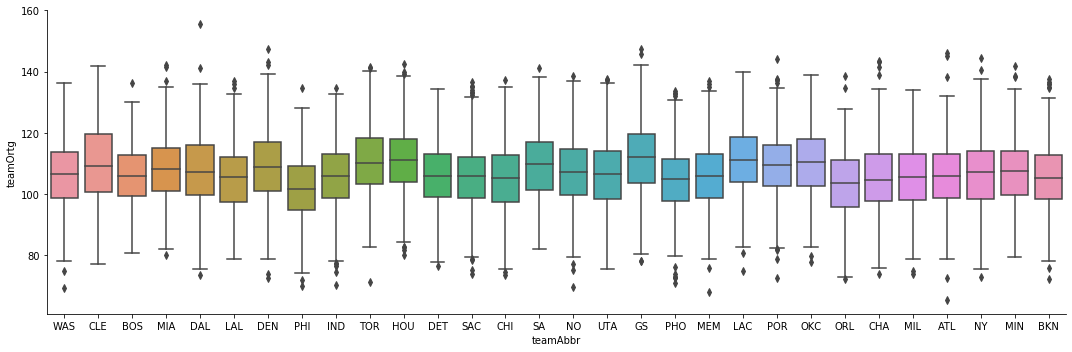

In [8]:
sns.catplot(x="teamAbbr", y="teamOrtg", data=teams_adj, kind='box', aspect=3);

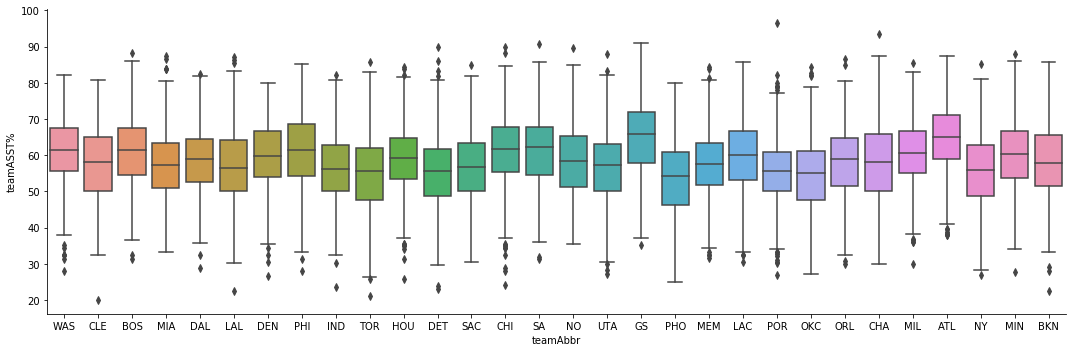

In [9]:
sns.catplot(x="teamAbbr", y="teamASST%", data=teams_adj, kind='box', aspect=3);

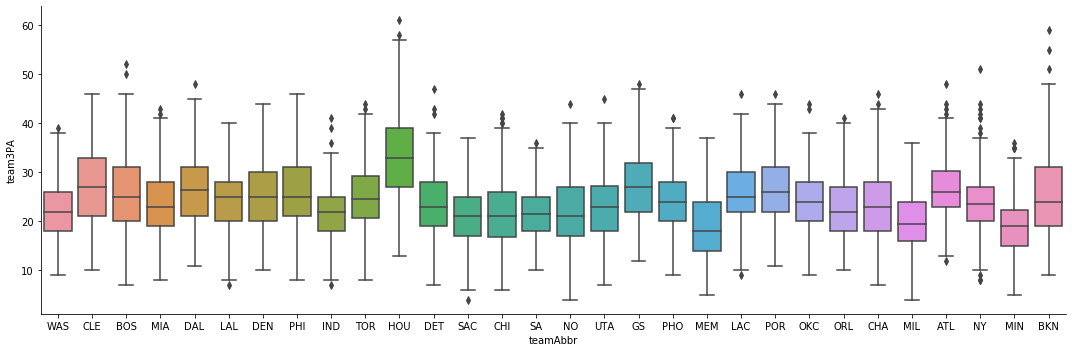

In [10]:
sns.catplot(x="teamAbbr", y="team3PA", data=teams_adj, kind='box', aspect=3);

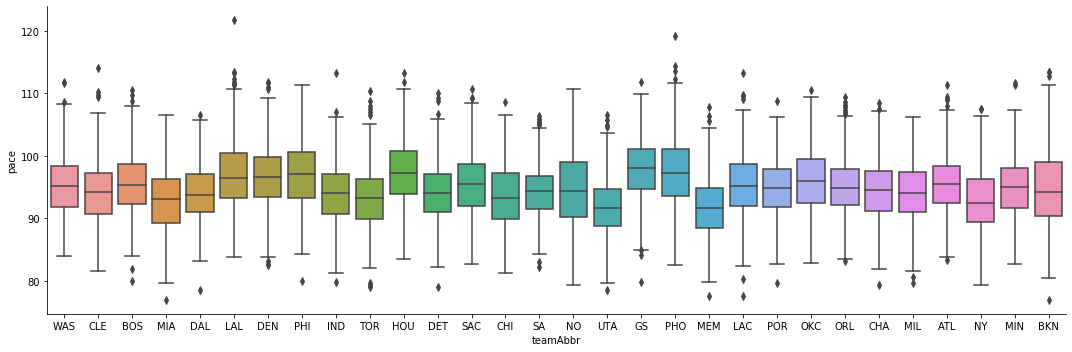

In [11]:
sns.catplot(x="teamAbbr", y="pace", data=teams_adj, kind='box', aspect=3);

Clearly there is enough variations between clubs so that classification would allow the creation of distinct and meaningful groups. 

#### Correlations

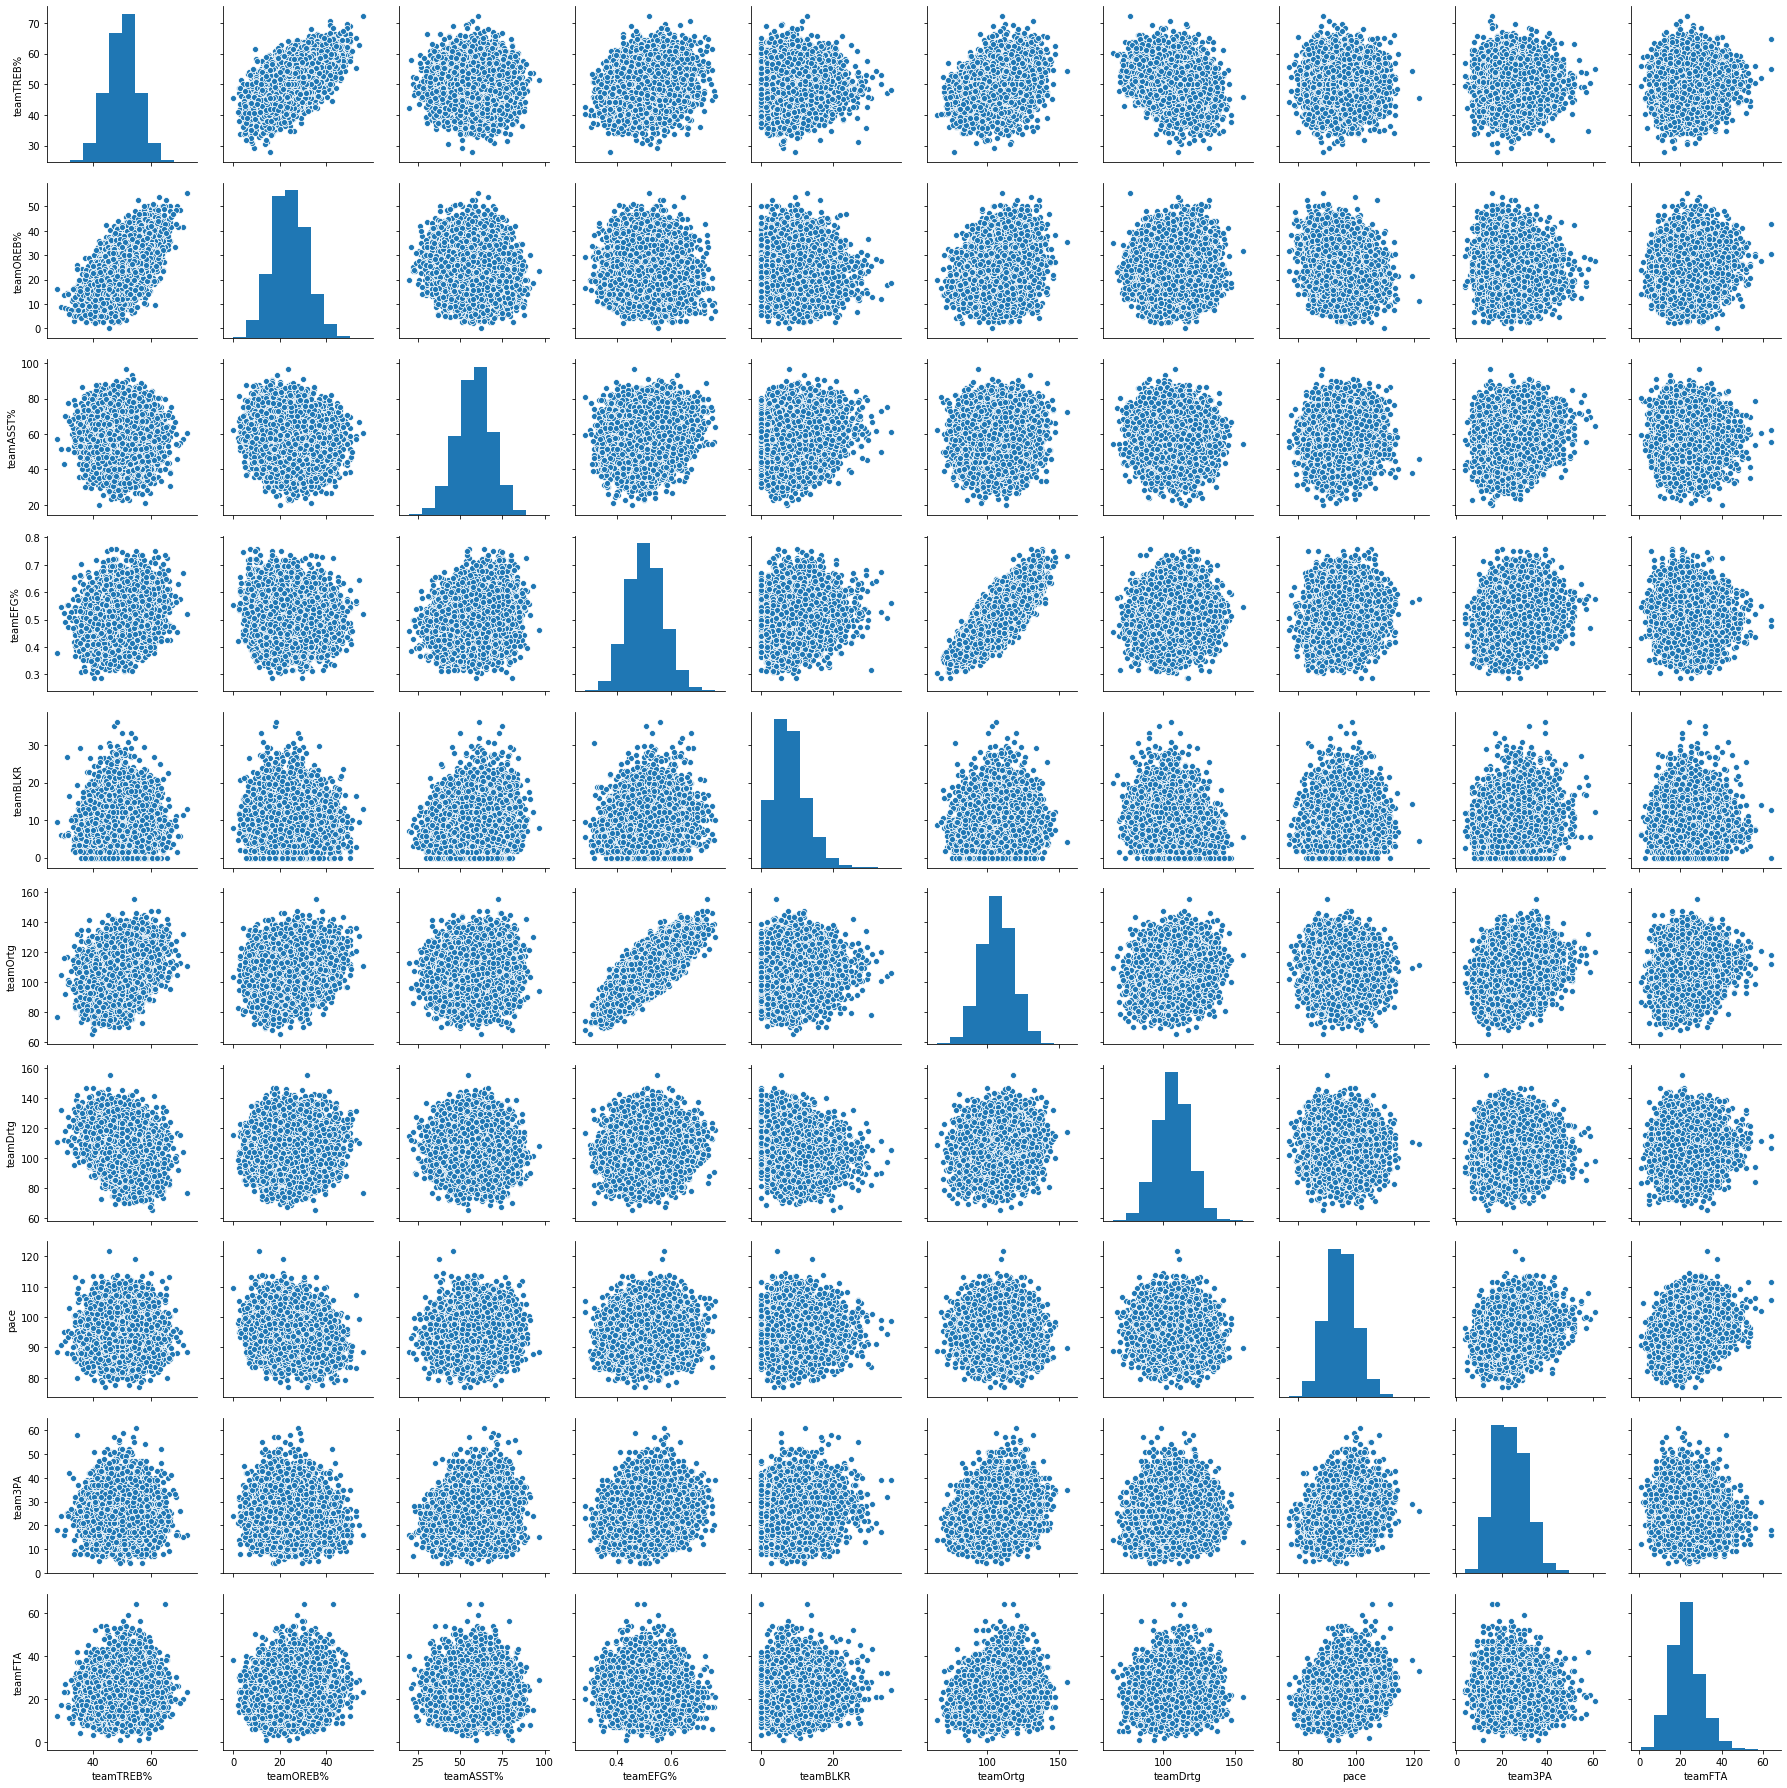

In [12]:
sns.pairplot(teams_adj)

Clearly the data are nicely distributed. The only issue is that `teamOrtg` and `teamEFG%` are highly positively correlated, hence one of the two should be remove. Same is ture for `teamOREB%` and `teamTREB%`.

Therefore I remove `teamTREB%` because I like to know in particular the teams which collect many offensive rebounds I also remove `teamEFG%`.

In [13]:
del teams_adj['teamEFG%']
del teams_adj['teamTREB%']

## Clustering

I perform a KMeans algorihtm to create the groups.

Because I do not want to predict which NBA franchise belongs to which cluster, I use 100% of the data to train my model. The clusters will then be used to help analyse the performances of Damian Lillard. 

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Scale the data 

In [15]:
scaler = StandardScaler()
teams_scaled = scaler.fit_transform(teams_adj.iloc[:, 1:])
teams_scaled

array([[ 1.19962228e+00,  2.22381899e+00,  1.98474786e+00, ...,
        -1.14925169e+00,  1.12214142e+00, -3.76593060e-01],
       [ 2.88919062e+00,  2.55680141e-01,  5.17996863e-02, ...,
        -1.14925169e+00, -5.60571873e-01, -1.07138955e-01],
       [-7.65603813e-01,  2.97449183e-01, -1.10548215e+00, ...,
         2.10910836e-02, -1.54215463e+00,  7.01223362e-01],
       ...,
       [-1.18780810e+00, -1.18772658e+00,  1.23615708e+00, ...,
         5.42683200e-01,  3.32559546e-04, -9.15501272e-01],
       [-1.08467202e+00, -2.24882050e+00,  1.85803511e+00, ...,
        -6.33295996e-01,  3.08530694e+00, -1.45440948e+00],
       [-1.11241307e+00, -5.86529058e-02, -5.91796121e-01, ...,
        -5.59363911e-01,  2.80784776e-01, -3.76593060e-01]])

### Fit the model

In [16]:
# Fit the model
model = KMeans(n_clusters=3, random_state=0)
model.fit(teams_scaled)

# Labels 
labels = model.labels_

# Centers 
centers = model.cluster_centers_

In [17]:
centers_df = pd.DataFrame(centers, columns=teams_adj.columns[1:])
centers_df['cluster'] = centers_df.index
centers_df

teamOREB%  teamASST%  teamBLKR  teamOrtg  teamDrtg      pace   team3PA  \
0  -0.420523   0.528296  0.480972  0.239878 -0.076212  0.679058  0.829200   
1   0.729477  -0.331496 -0.297441  0.589192  0.523024 -0.326416 -0.265903   
2  -0.286895  -0.160758 -0.150242 -0.732079 -0.400217 -0.295448 -0.478996   

    teamFTA  cluster  
0  0.090554        0  
1  0.394461        1  
2 -0.429649        2

In [65]:
# Function that creates Parallel Plots
def parallel_plot(data):
	my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
	plt.figure(figsize=(15,8)).gca().axes.set_ylim([-1,+1])
	parallel_coordinates(data, 'cluster', color = my_colors, marker='o')

Text(0.5, 0, 'Features')

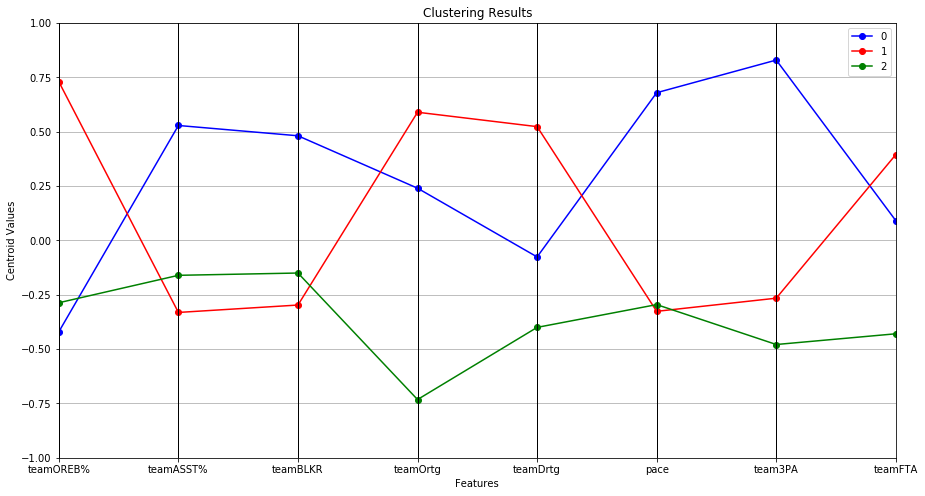

In [66]:
parallel_plot(centers_df)
plt.title('Clustering Results')
plt.ylabel('Centroid Values')
plt.xlabel('Features')

In [20]:
# Per Line
scaled_df = pd.DataFrame(teams_scaled, columns=teams_adj.columns[1:])
scaled_df['teamAbbr'] = teams_adj['teamAbbr'].reset_index(drop=True)
scaled_df['cluster'] = labels
scaled_df.head()

teamOREB%  teamASST%  teamBLKR  teamOrtg  teamDrtg      pace   team3PA  \
0   1.199622   2.223819  1.984748 -1.115732 -0.121268 -1.149252  1.122141   
1   2.889191   0.255680  0.051800 -0.121268 -1.115732 -1.149252 -0.560572   
2  -0.765604   0.297449 -1.105482  0.494621  1.705171  0.021091 -1.542155   
3  -1.503687  -0.034729 -0.066843  1.705171  0.494621  0.021091 -1.121476   
4  -0.228060  -0.341547 -0.241820  0.092351 -0.680294 -0.638274 -1.261702   

    teamFTA teamAbbr  cluster  
0 -0.376593      WAS        0  
1 -0.107139      CLE        1  
2  0.701223      BOS        1  
3  1.240132      MIA        1  
4 -0.646047      DAL        2

Check if the clusters are well "spread" (not one cluster that dominate the others). 

In [21]:
scaled_df[['teamAbbr', 'cluster']].groupby('cluster').count()

teamAbbr
cluster          
0            4624
1            4776
2            5358

See what the groups look like using a pairplot. 

/Users/antoinegex-fabry/anaconda/envs/Python4DS/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/antoinegex-fabry/anaconda/envs/Python4DS/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


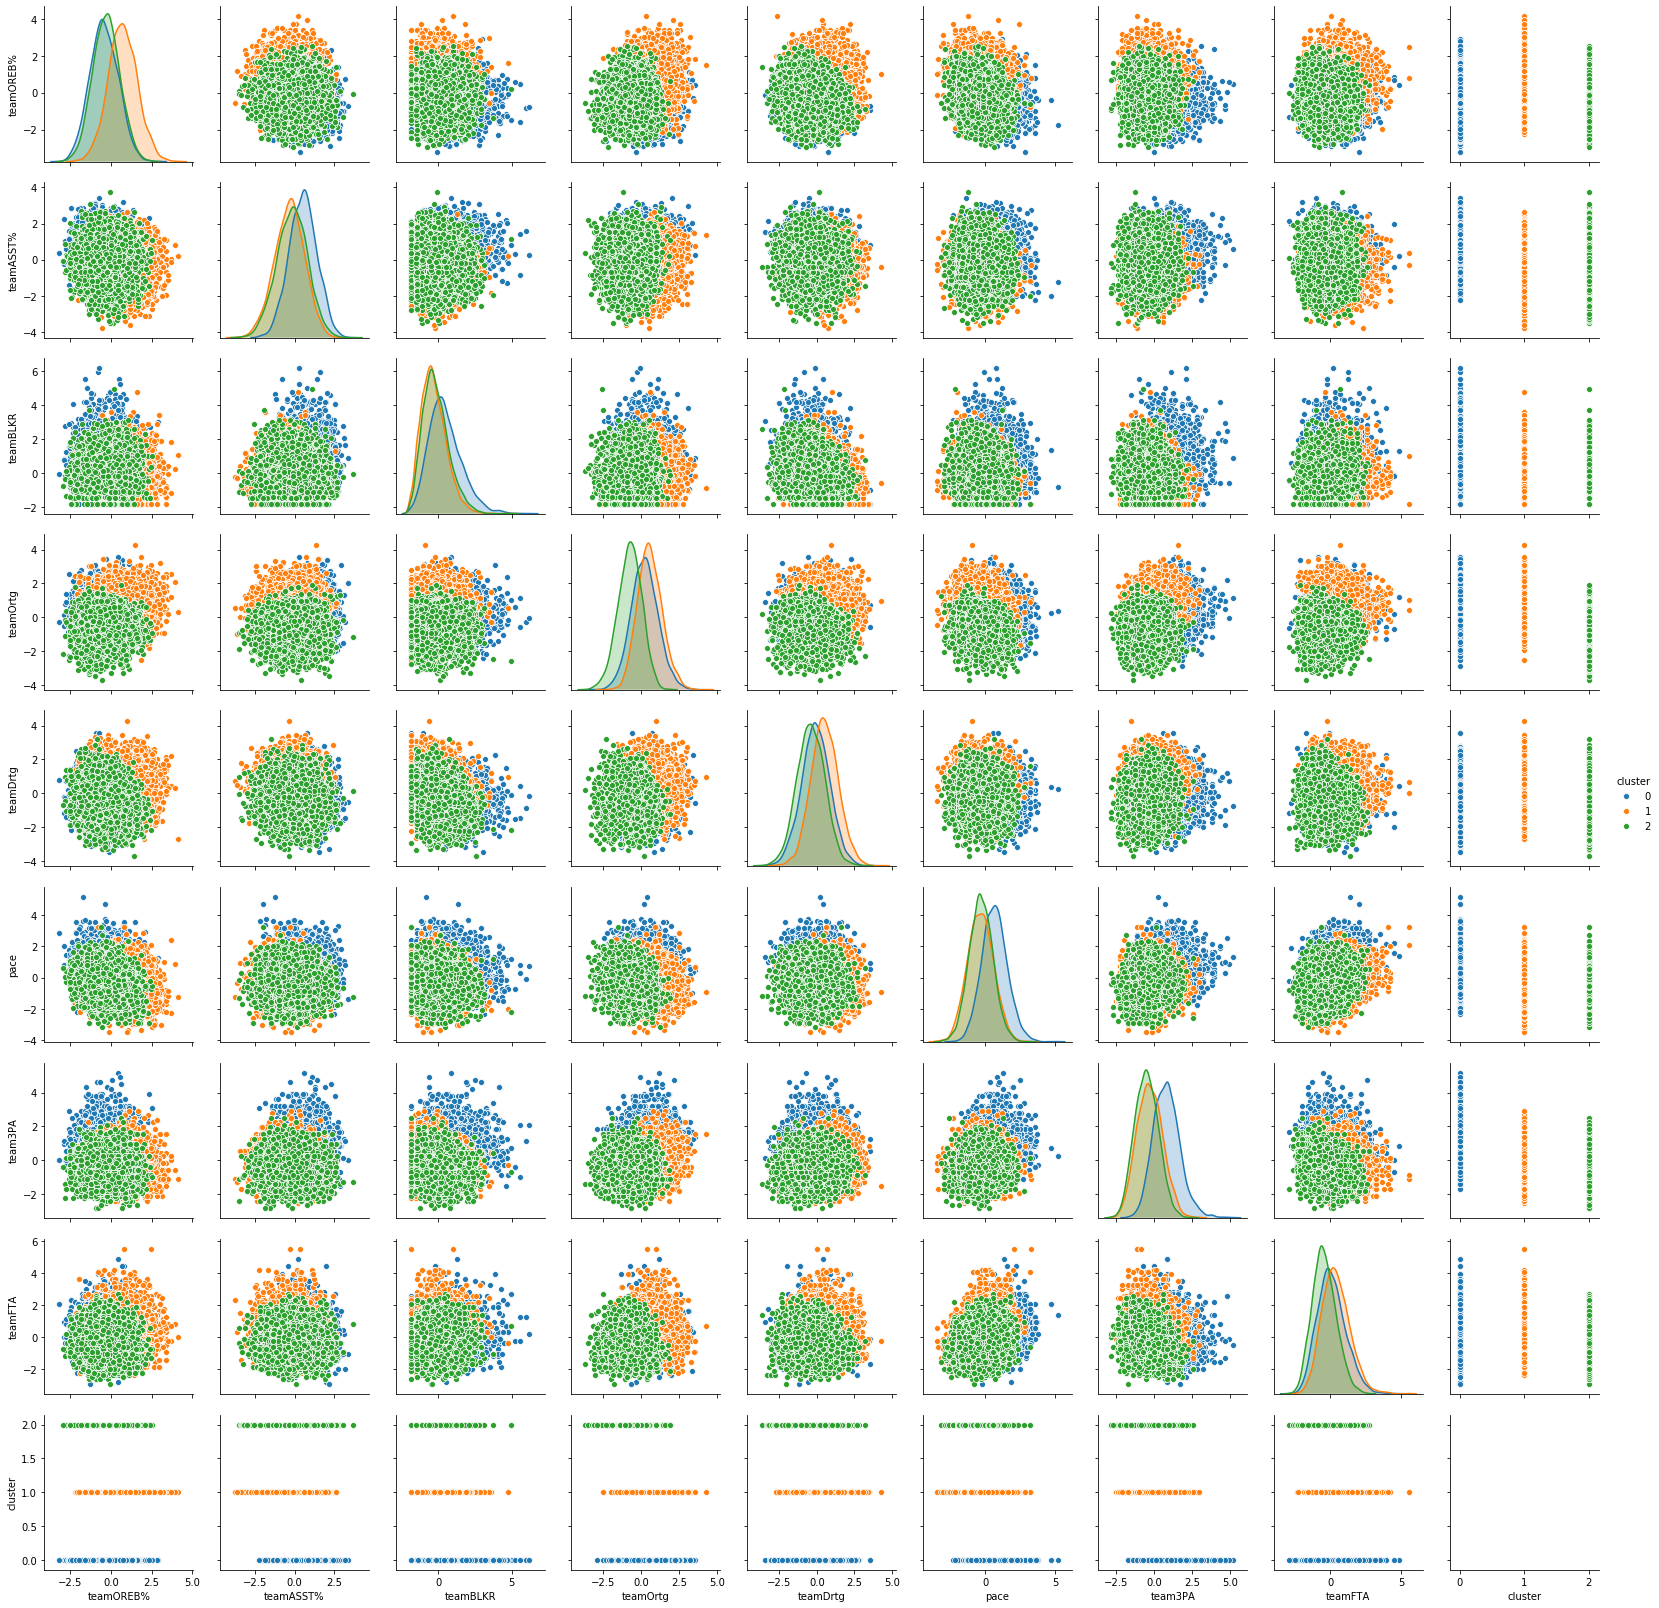

In [22]:
sns.pairplot(scaled_df, hue='cluster')

## Save the data 

For simplicity, I save a dataset with all the elements that will allow me to join the clusters to the `2017-18_playerBoxScore.csv` dataset. 

To do so, I only need the dates and team names.

In [23]:
cluster_data = pd.DataFrame({
    'gmDate': teams['gmDate'],
    'opptAbbr': teams['teamAbbr'], 
    'cluster': labels
})
mask1 = cluster_data['opptAbbr'] == 'LAL'
mask2 = cluster_data['gmDate'] == '2012-10-31' 
mask3 = cluster_data['opptAbbr'] == 'OKC'
mask4 = cluster_data['gmDate'] == '2012-11-02' 
cluster_data[(mask1 & mask2) | (mask3 & mask4)]

gmDate opptAbbr  cluster
22  2012-10-31      LAL        1
43  2012-11-02      OKC        2

In [24]:
cluster_data.to_csv('data/cluster_data.csv', index=False)

## Short Analysis of a team's style over time

I analyse how the Portland Trailblazers' style of play has evolved. I do the same for the Golden State Warriors who have noticeably changed dimensions from 2014 and their first title, then from 2016 when Kevin Durant joined as a free agent. I also do the same for Sacramento, who have been known for not being good during these years. 

This is a way for me to see if the clusters can be used to track a team's change in playstyle. 

### Portland Trailblazers

In [25]:
# Store the dates
end_season1 = '2013-06-20'
end_season2 = '2014-06-15'
end_season3 = '2015-06-16'
end_season4 = '2016-06-29'
end_season5 = '2017-06-12'
end_season6 = '2018-06-08'

season = []
for ele in cluster_data['gmDate']: 
    if ele < end_season1:
        season.append('12-13')
    elif ele <= end_season2: 
        season.append('13-14')
    elif ele <= end_season3: 
        season.append('14-15')
    elif ele <= end_season4: 
        season.append('15-16')
    elif ele <= end_season5: 
        season.append('16-17')
    elif ele <= end_season6: 
        season.append('17-18')

cluster_data['seasonNmbr'] = season

In [60]:
portland = cluster_data[cluster_data['opptAbbr'] == 'POR']

In [27]:
portland_evo = portland.groupby(['cluster', 'seasonNmbr']).count().unstack().iloc[:, :6]
portland_evo = portland_evo['gmDate'].reset_index()

Text(0, 0.5, 'Number of games\nbelonging to a cluster')

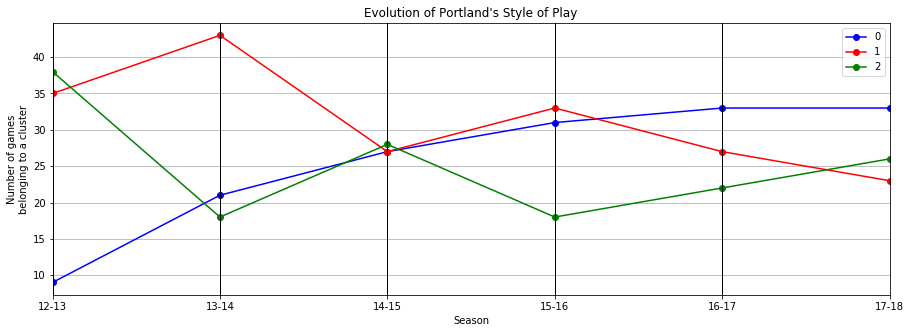

In [28]:
my_colors = ['b', 'r', 'g', 'y', 'k']
plt.figure(figsize=(15,5)).gca()
parallel_coordinates(portland_evo,'cluster', color = my_colors, marker='o')
plt.title('Evolution of Portland\'s Style of Play')
plt.xlabel('Season')
plt.ylabel('Number of games\nbelonging to a cluster')

#### Golden State Warriors

In [29]:
gsw = cluster_data[cluster_data['opptAbbr'] == 'GS']
gsw_evo = gsw.groupby(['cluster', 'seasonNmbr']).count().unstack().iloc[:, :6]
gsw_evo = gsw_evo['gmDate'].reset_index()
gsw_evo

seasonNmbr  cluster  12-13  13-14  14-15  15-16  16-17  17-18
0                 0      9     28     60     67     76     71
1                 1     29     23      9      8      3      5
2                 2     44     31     13      7      3      6

Text(0, 0.5, 'Number of games\nbelonging to a cluster')

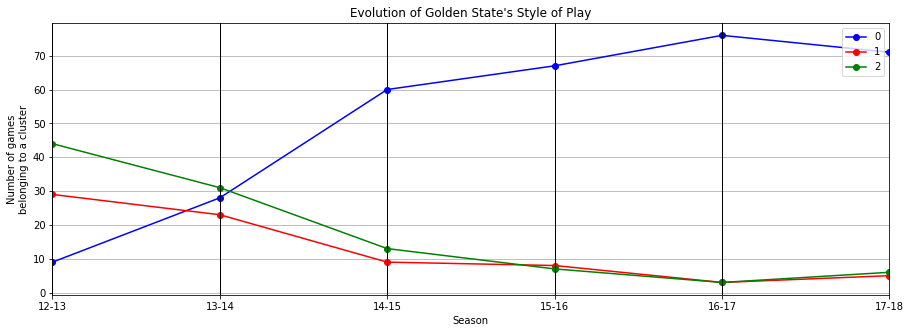

In [30]:
my_colors = ['b', 'r', 'g', 'y', 'k']
plt.figure(figsize=(15,5)).gca()
parallel_coordinates(gsw_evo,'cluster', color = my_colors, marker='o')
plt.title('Evolution of Golden State\'s Style of Play')
plt.xlabel('Season')
plt.ylabel('Number of games\nbelonging to a cluster')

### Sacramento Kings

In [77]:
sac = cluster_data[cluster_data['opptAbbr'] == 'SAC']
sac_evo = sac.groupby(['cluster', 'seasonNmbr']).count().unstack().iloc[:, :6]
sac_evo = sac_evo['gmDate'].reset_index()
sac_evo

seasonNmbr  cluster  12-13  13-14  14-15  15-16  16-17  17-18
0                 0      6      5      6     33     24     17
1                 1     41     46     43     28     26     18
2                 2     35     31     33     21     32     47

Text(0, 0.5, 'Number of games\nbelonging to a cluster')

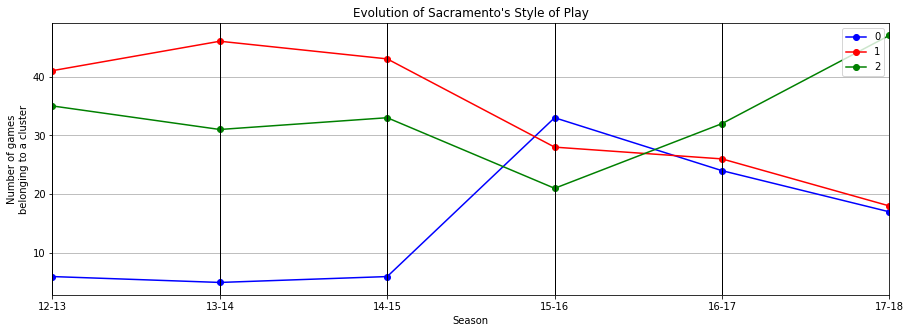

In [78]:
my_colors = ['b', 'r', 'g', 'y', 'k']
plt.figure(figsize=(15,5)).gca()
parallel_coordinates(sac_evo,'cluster', color = my_colors, marker='o')
plt.title('Evolution of Sacramento\'s Style of Play')
plt.xlabel('Season')
plt.ylabel('Number of games\nbelonging to a cluster')